# Fitting Saturation-based Simulation Data With Multi-Output
Can having multiple labels per data improve validation loss? 


In [95]:
from pathlib import Path
import json
from torch.optim import Adam, SGD
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from model_trainer import RandomSplit, ValidationMethod, HoldOneOut, CVSplit, CombineMethods
from inverse_modelling_tfo.model_training.custom_models import (
    PerceptronBD,
    CNN2FC,
    FeatureResidualNetwork,
    CNN2FC2dInput,
    SplitChannelCNN
)

from inverse_modelling_tfo.visualization import generate_model_error_and_prediction
import torchinfo
from inverse_modelling_tfo.misc.misc_training import set_seed

# Set my GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [96]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Pre-save data

In [97]:
# file_name = 'logI2_by_I1'
# file_name = 'I1_and_I2'
# file_name = 'pulsation_ratio'
file_name = "I1_and_I2_interp"
# Load data
DATA_PATH = Path().resolve().parent.parent / "data" / "processed_data" / f"{file_name}.pkl"
data = pd.read_pickle(DATA_PATH)

# Load Configs
CONFIG_PATH = DATA_PATH.with_suffix(".json")
with open(CONFIG_PATH, "r") as f:
    config = json.load(f)
labels = config["labels"]
features = config["features"]

# Convert to log
# data[features] = np.log(data[features])



In [98]:
# I1 by I2 path

from inverse_modelling_tfo.features.build_features import TwoColumnOperationFeatureBuilder

i1_wv2 = features[:len(features)//4]
i1_wv1 = features[len(features)//4:2*len(features)//4]
i2_wv2 = features[2*len(features)//4:3*len(features)//4]
i2_wv1 = features[3*len(features)//4:]


# Create the feature builders
fb1 = TwoColumnOperationFeatureBuilder(i2_wv1, i1_wv1, '/', False, features, labels)
fb2 = TwoColumnOperationFeatureBuilder.from_chain(fb1, i2_wv2, i1_wv2, '/', False)

# Transform the data
data = fb2(data)

features = fb2.get_feature_names()

# Cleanup
data.dropna(inplace=True)

In [99]:
data.describe()

,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Saturation,FconcCenters,Fetal Hb Concentration 1,Fetal Hb Concentration 2,10_1.0_2_/_10_1.0_1,15_1.0_2_/_15_1.0_1,19_1.0_2_/_19_1.0_1,...,55_2.0_2_/_55_2.0_1,59_2.0_2_/_59_2.0_1,64_2.0_2_/_64_2.0_1,68_2.0_2_/_68_2.0_1,72_2.0_2_/_72_2.0_1,77_2.0_2_/_77_2.0_1,81_2.0_2_/_81_2.0_1,86_2.0_2_/_86_2.0_1,90_2.0_2_/_90_2.0_1,94_2.0_2_/_94_2.0_1
count,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,...,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000
mean,19.000000,13.000000,0.950000,0.400000,4.000000,12.675000,13.000000,0.999966,0.999818,0.999558,...,0.996413,0.995981,0.996017,0.995063,0.994112,0.992926,0.991981,0.990801,0.989861,0.988923
std,8.944281,1.290996,0.031623,0.121106,2.738615,1.335075,1.369308,0.000108,0.000499,0.001104,...,0.006326,0.007032,0.004931,0.004793,0.004959,0.005544,0.006238,0.007291,0.008230,0.009225
min,4.000000,11.000000,0.900000,0.200000,0.000000,10.725000,11.000000,0.999422,0.997501,0.994738,...,0.979319,0.976901,0.986528,0.986379,0.983319,0.976999,0.971972,0.965725,0.960757,0.955814
25%,11.000000,12.000000,0.920000,0.300000,1.750000,11.578125,11.875000,0.999996,0.999974,0.999881,...,0.996449,0.995897,0.990542,0.989976,0.989586,0.989104,0.988439,0.987662,0.986722,0.985239
50%,19.000000,13.000000,0.950000,0.400000,4.000000,12.675000,13.000000,0.999999,0.999999,0.999999,...,0.999974,0.999970,1.000000,0.997142,0.994893,0.992200,0.990703,0.989951,0.989624,0.989139
75%,27.000000,14.000000,0.980000,0.500000,6.250000,13.771875,14.125000,1.000001,1.000000,1.000000,...,0.999999,0.999999,1.000144,0.999781,0.999366,0.998856,0.998452,0.997949,0.997548,0.997147
max,34.000000,15.000000,1.000000,0.600000,8.000000,14.625000,15.000000,1.000017,1.000010,1.000008,...,1.000005,1.000006,1.001560,1.000000,1.000000,1.000000,0.999999,0.999999,0.999999,0.999999


In [100]:
# Filter data so I don't have to wait for too long during training
data = data[
    (data["Maternal Wall Thickness"] >= 2.0)
    & (data["Maternal Wall Thickness"] <= 24.0)
]
print("training with", len(data), "samples")

training with 349272 samples


# Setup Training Objective

In [101]:
## Regression
# y_columns = labels  # What to Predict
y_columns = ['Fetal Saturation']  # What to Predict

## Classification
## Convert the Fetal Saturation values to One-Hot Encoding
# data["Fetal Saturation"] = data["Fetal Saturation"].round(2)
# data = pd.get_dummies(data, columns=["Fetal Saturation"], prefix="FS")
# y_columns = [col for col in data.columns if col.startswith("FS_")]


# Add New ConcDiff Column as a new label
# data["ConcDiff"] = data["Fetal Hb Concentration 1"] - data["Fetal Hb Concentration 0"]
# if "ConcDiff" not in y_columns:
#     y_columns.append("ConcDiff")

# if "Fetal Hb Concentration 1" in y_columns:
#     y_columns.remove("Fetal Hb Concentration 1")

# if "Fetal Hb Concentration 0" in y_columns:
#     y_columns.remove("Fetal Hb Concentration 0")

if "FconcCenters" in y_columns:
    y_columns.remove("FconcCenters")
print("Y Columns", y_columns)

x_columns = features  # What to use as input

## Use only first N detectors
# N = 10
# x_columns = features[:N] + features[(len(features)//2): (len(features)//2 + N)]

print("X Columns", x_columns)

Y Columns ['Fetal Saturation']
X Columns ['10_1.0_2_/_10_1.0_1', '15_1.0_2_/_15_1.0_1', '19_1.0_2_/_19_1.0_1', '24_1.0_2_/_24_1.0_1', '28_1.0_2_/_28_1.0_1', '33_1.0_2_/_33_1.0_1', '37_1.0_2_/_37_1.0_1', '41_1.0_2_/_41_1.0_1', '46_1.0_2_/_46_1.0_1', '50_1.0_2_/_50_1.0_1', '55_1.0_2_/_55_1.0_1', '59_1.0_2_/_59_1.0_1', '64_1.0_2_/_64_1.0_1', '68_1.0_2_/_68_1.0_1', '72_1.0_2_/_72_1.0_1', '77_1.0_2_/_77_1.0_1', '81_1.0_2_/_81_1.0_1', '86_1.0_2_/_86_1.0_1', '90_1.0_2_/_90_1.0_1', '94_1.0_2_/_94_1.0_1', '10_2.0_2_/_10_2.0_1', '15_2.0_2_/_15_2.0_1', '19_2.0_2_/_19_2.0_1', '24_2.0_2_/_24_2.0_1', '28_2.0_2_/_28_2.0_1', '33_2.0_2_/_33_2.0_1', '37_2.0_2_/_37_2.0_1', '41_2.0_2_/_41_2.0_1', '46_2.0_2_/_46_2.0_1', '50_2.0_2_/_50_2.0_1', '55_2.0_2_/_55_2.0_1', '59_2.0_2_/_59_2.0_1', '64_2.0_2_/_64_2.0_1', '68_2.0_2_/_68_2.0_1', '72_2.0_2_/_72_2.0_1', '77_2.0_2_/_77_2.0_1', '81_2.0_2_/_81_2.0_1', '86_2.0_2_/_86_2.0_1', '90_2.0_2_/_90_2.0_1', '94_2.0_2_/_94_2.0_1']


## Normalizing Features
x_columns will be the input features and y_columns are the target

In [102]:
## Pass in maternal info
# x_columns += ["Maternal Hb Concentration", "Maternal Saturation"]
# x_columns = list(filter(lambda X: 'alpha' in X, data.columns))
## Scale y
y_scaler = preprocessing.StandardScaler()
data[y_columns] = y_scaler.fit_transform(data[y_columns])

## Scale x
## Scheme 1 - Per detector normalization
x_scaler = preprocessing.StandardScaler()
data[x_columns] = x_scaler.fit_transform(data[x_columns])

## Scheme 2 - All detector combined normalization
# x_scaler = preprocessing.StandardScaler()
# # Assume the entire data lies between -1 to -20 (log scale) -> z = (x - u) / s -> zs - x = -u; s = 19/2 = 9.5;
# # at z = +1, x = -1, at z = -1, x = -20, u = 10.5, so we should be converting from -1 to -20 to -1 to 1
# # Use these values to manually define the scaler
# feature_len  = len(x_columns)
# x_scaler.scale_ = np.array([9.5] * feature_len)
# x_scaler.mean_ = np.array([10.5] * feature_len)
# x_scaler.n_features_in_ = feature_len
# x_scaler.feature_names_in_ = x_columns  # Avoids a warning/not really necessary
# data[x_columns] = x_scaler.transform(data[x_columns])


## Model Configuration

In [103]:
print("In Features :", len(x_columns))  
print("Out Features:", len(y_columns))

In Features : 40
Out Features: 1


# Training Configs

In [159]:
IN_FEATURES = len(x_columns)
OUT_FEATURES = len(y_columns)

from model_trainer import ModelTrainer, TorchLossWrapper, DataLoaderGenerator, SumLoss
from model_trainer.ModelTrainer import ModelTrainerNoisy
from model_trainer.early_stopping import EarlyStopper

## Create an individual loss for each label
# criterion_list = []
# criterion_names = ['depth', 'mom_hb', 'mom_sat', 'fet_sat', 'fet_hb1', 'fet_hb2']

# for index, name in enumerate(criterion_names):
#     criterion_list.append(TorchLossWrapper(nn.MSELoss(), [index], name))

# Sum the losses
# criterion = SumLoss(criterion_list, weights=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

## Lump All Losses into one
criterion = TorchLossWrapper(nn.MSELoss(), name="fetal_sat")
# criterion = TorchLossWrapper(nn.CrossEntropyLoss(), name='fetal_sat')


set_seed(40)

## Validation Methods
# validation_method = RandomSplit(0.7)
all_depths = data["Maternal Wall Thickness"].unique()
all_depths.sort()
validation_method = HoldOneOut("Maternal Wall Thickness", all_depths[len(all_depths) // 2])  # Center value

dataloader_gen = DataLoaderGenerator(data, x_columns, y_columns, 32, {"shuffle": True})

## Trainer Factory - Perceptrons
# model = PerceptronBD([IN_FEATURES, 40, 20, 10, 6, OUT_FEATURES])    # Works
# model = PerceptronBD([IN_FEATURES, 40, 20, OUT_FEATURES])     # Current Best
model = PerceptronBD([IN_FEATURES, 20, 15, 10, 5, 3, OUT_FEATURES])
# model = PerceptronBD([IN_FEATURES, 20, 10, OUT_FEATURES])


## Trainer Factory - CNNs
# cnn_config = {
#     'input_length': IN_FEATURES,
#     'cnn_out_channels': [4, 8, 16],
#     'cnn_kernel_sizes' : [10, 10, 10],
#     'fc_output_node_counts': [20, 10, OUT_FEATURES],
# }
# trainer_factory = ModelTrainerFactory(CNN2FC2dInput, cnn_config, generate_data_loaders, datagen_kw, 100, criterion)

## Trainer Factory - SplitChannel CNNs
# cnn_config = {
#     'complete_input_length': IN_FEATURES,
#     'split_count': 2,
#     'cnn_out_channels': [4, 8, 16],
#     # 'cnn_kernel_sizes' : [10, 5, 5],
#     'cnn_kernel_sizes' : [10, 5, 3],
#     # 'cnn_dropouts' : [0.1] * 2,
#     'fc_output_node_counts': [12, 6, OUT_FEATURES],    # Best
#     # 'fc_dropouts': [0.1] * 3,
# }

# model = SplitChannelCNN(**cnn_config)


# trainer = ModelTrainer(model, dataloader_gen, validation_method, criterion)
trainer = ModelTrainerNoisy(
    model,
    dataloader_gen,
    validation_method,
    criterion,
    list(range(len(x_columns))),
    [0.05] * len(x_columns),
    [0] * len(x_columns),
)

## Custom Training

In [160]:
# trainer.set_optimizer(SGD, {'lr': 4e-4, 'momentum': 0.98, 'weight_decay': 1e-4})
# trainer.set_optimizer(SGD, {'lr': 2e-3, 'momentum': 0.98, 'weight_decay': 1e-4})      # Current Best
# trainer.set_optimizer(SGD, {'lr': 3e-4, 'momentum': 0.98, 'nesterov': True})
trainer.set_optimizer(SGD, {'lr': 3e-4, 'momentum': 0.98, 'nesterov': True, 'weight_decay': 0.01})
trainer.set_batch_size(32)
# trainer.set_batch_size(32)
trainer.run(20) 

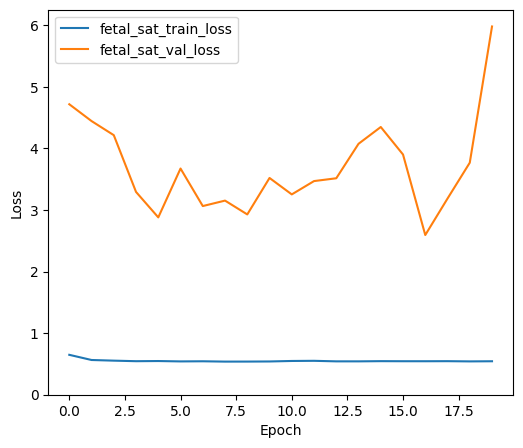

In [161]:
loss_curves = criterion.plot_losses()
plt.show()

In [162]:
criterion.print_table()

                   Losses                   
┏━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃    👀     ┃ Train Loss ┃ Validation Loss ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ fetal_sat │   0.5435   │     5.9801      │
└───────────┴────────────┴─────────────────┘

In [163]:
# Increase batch_size for faster visuals generation - (does not affect training!)
prev_batch_size = dataloader_gen.batch_size
trainer.set_batch_size(4096)
train_error, train_pred = generate_model_error_and_prediction(trainer.model, trainer.train_loader, y_columns, y_scaler)
val_error, val_pred = generate_model_error_and_prediction(trainer.model, trainer.validation_loader, y_columns, y_scaler)
trainer.set_batch_size(prev_batch_size)

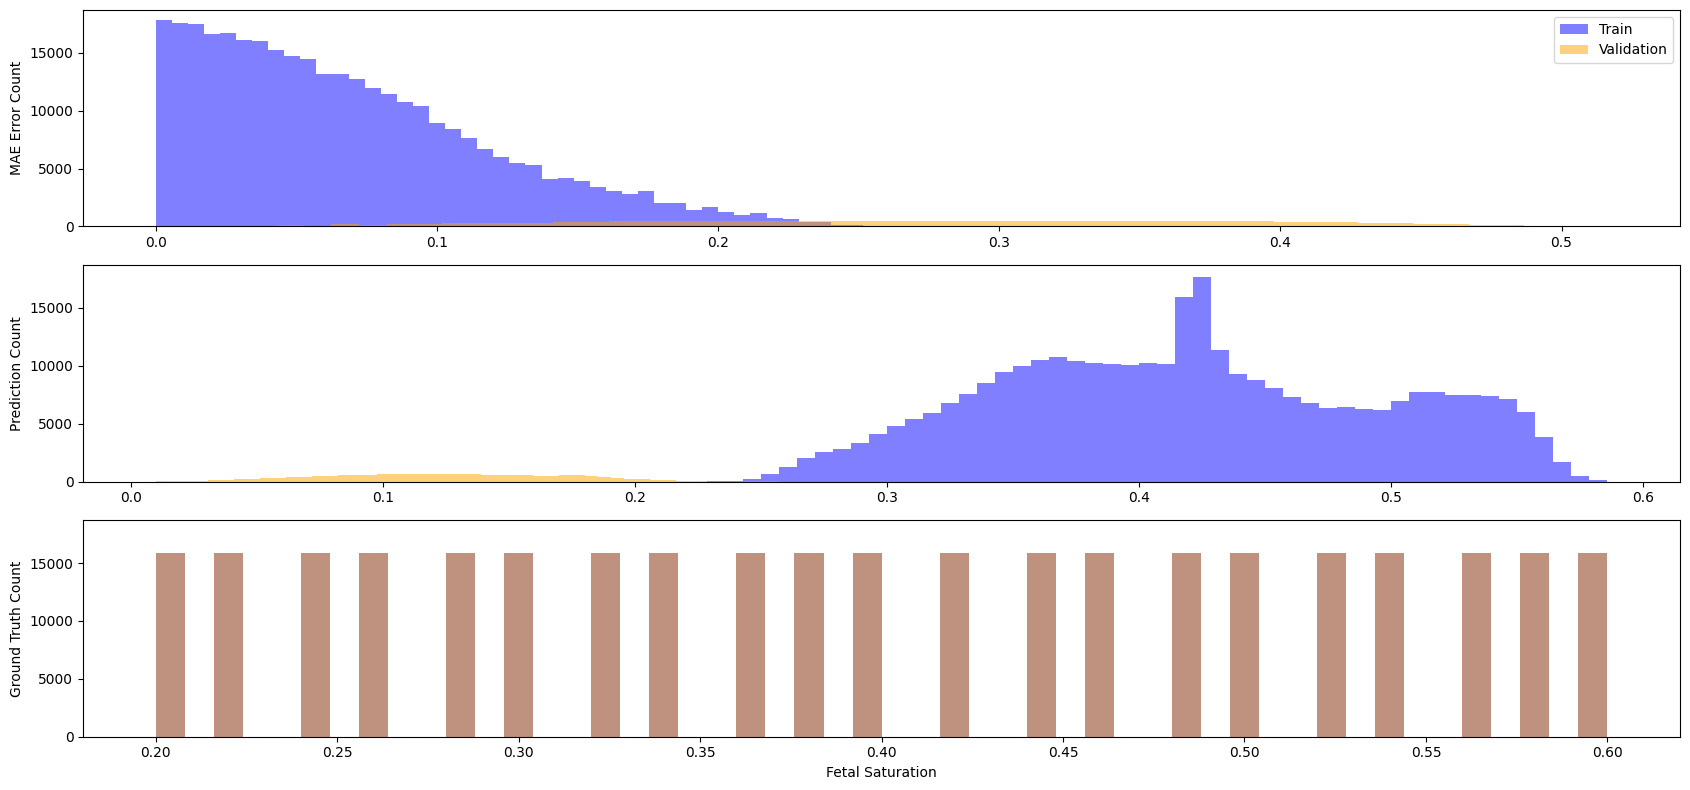

In [164]:
from inverse_modelling_tfo.visualization.visualize import plot_error_pred_truth_dist

plot_error_pred_truth_dist(trainer.train_loader.dataset, train_pred, val_pred, train_error, val_error, y_columns, y_scaler)
plt.show()

In [165]:
from inverse_modelling_tfo.visualization import create_error_stats_table
print("Printing MAE Errors...")
create_error_stats_table(train_error, val_error)

Printing MAE Errors...


                                   Error Statistics                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Label                  ┃ Train Mean ┃ Train Std ┃ Validation Mean ┃ Validation Std ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ Fetal Saturation Error │     0.0688 │    0.0511 │          0.2750 │         0.1098 │
└────────────────────────┴────────────┴───────────┴─────────────────┴────────────────┘

In [166]:
# Model Info
torchinfo.summary(trainer.model)

Layer (type:depth-idx)                   Param #
PerceptronBD                             --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       820
│    └─BatchNorm1d: 2-2                  40
│    └─ReLU: 2-3                         --
│    └─Linear: 2-4                       315
│    └─BatchNorm1d: 2-5                  30
│    └─ReLU: 2-6                         --
│    └─Linear: 2-7                       160
│    └─BatchNorm1d: 2-8                  20
│    └─ReLU: 2-9                         --
│    └─Linear: 2-10                      55
│    └─BatchNorm1d: 2-11                 10
│    └─ReLU: 2-12                        --
│    └─Linear: 2-13                      18
│    └─BatchNorm1d: 2-14                 6
│    └─ReLU: 2-15                        --
│    └─Linear: 2-16                      4
│    └─Flatten: 2-17                     --
Total params: 1,478
Trainable params: 1,478
Non-trainable params: 0

In [167]:
# ## Save Model Code
# model_name = 'multi_output_holdoneout_split'
# import joblib
# # Save Model
# torch.save(model.state_dict(), rf'../../models/{model_name}')
# # Save the Scalers for Later Use
# joblib.dump(x_scaler, rf'../../models/{model_name}_xscaler')
# joblib.dump(y_scaler, rf'../../models/{model_name}_yscaler')

In [168]:
# # Load Model Code
# model = PerceptronReLU([20, 10, 4, 2, 1])
# model.load_state_dict(torch.load(r'../models/fsat_delta_5det_v1'))
# model = model.cuda()
# x_scaler = joblib.load(rf'../models/{model_name}_xscaler')
# y_scaler = joblib.load(rf'../models/{model_name}_yscaler')

In [169]:
# from inverse_modelling_tfo.misc import MarkdownReport
# # Generate report

# report = MarkdownReport(Path('results'), 'report7', 'Inverse Modelling Report')
# report.add_text_report("Objective", "Predicting with 90% Random Split(As opposed to a hold One out style). Same as report6. Except, trying out a different normalization scheme. Where it scales all detector intensity logs using a single scale. More specifically, maps the values from -1 to -20 between -1 and +1. The intuition behind this was that this sort of normalization should preserve inter-detector scaling.")
# report.add_text_report("Comments", "Somehow performs slightly worse than per detector scaling. Which does not make sense to me")
# report.add_text_report("Data Length", str(len(data)))
# report.add_code_report("Model Used", str(torchinfo.summary(trainer.model)))
# report.add_code_report("Model Trainer Params", str(trainer))
# report.add_image_report("Loss Curves", loss_curves)
# report.add_image_report("Prediction & Error Distribution", fig_dist)
# report.save_report()